# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
# Number of training examples
n_train = X_train.shape[0]

#Number of validation examples
n_validation = X_valid.shape[0]

#Number of testing examples.
n_test = X_test.shape[0]

#What's the shape of an traffic sign image?
image_shape = X_train[0].shape

#How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.append(np.append(y_train,y_test,axis=0),y_valid,axis=0)))

print("Number of training examples =", n_train)
print("Number of validating examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validating examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Total image class in train dataset : 


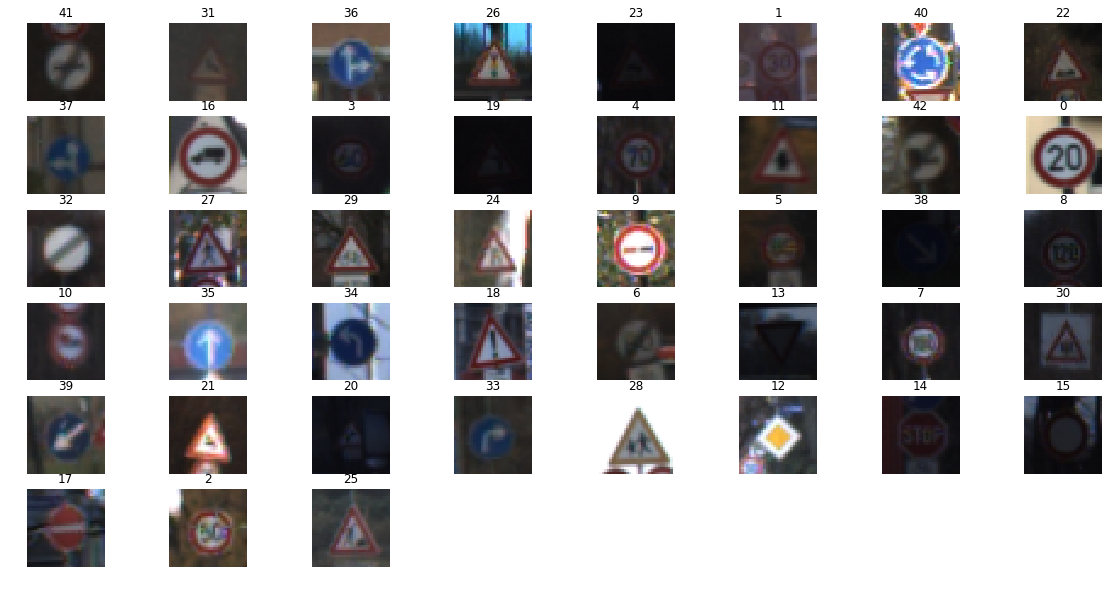

In [3]:
### Data exploration visualization code goes here.
import random
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline
signs = []
caches = []
for index, label in enumerate(y_train):
    if label not in caches:
        caches.append(label)
        signs.append((label, index))

# Show a random collection of the preprocessed images
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
print("Total image class in train dataset : ")
for index, sign in enumerate(signs):
    ax = fig.add_subplot(6, 8, index + 1)
    ax.axis('off')
    ax.set_title(sign[0])
    image = X_train[sign[1]].squeeze()
    ax.imshow(image)

### Distribution of classes in the training, validation and test set

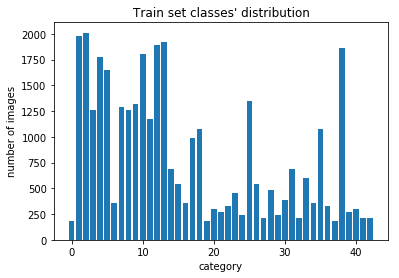

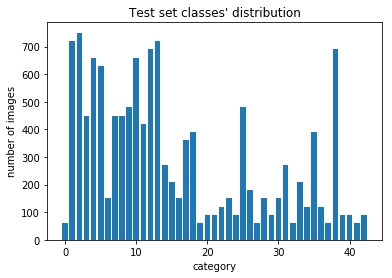

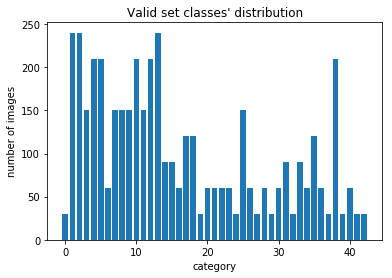

In [4]:
def count_sign(y):
    labels=np.zeros(n_classes)
    for i in range(0,len(y)):
        labels[y[i]] +=1
    return labels
    
y_train_dis= count_sign(y_train)
y_test_dis= count_sign(y_test)
y_valid_dis= count_sign(y_valid)
print("")
import matplotlib.pyplot as plt
plt.title('Train set classes\' distribution')
plt.xlabel('category')
plt.ylabel('number of images')
plt.bar(range(len(y_train_dis)), y_train_dis)
plt.show()

plt.xlabel('category')
plt.ylabel('number of images')
plt.title('Test set classes\' distribution')
plt.bar(range(len(y_test_dis)), y_test_dis)
plt.show()

plt.xlabel('category')
plt.ylabel('number of images')
plt.title('Valid set classes\' distribution')
plt.bar(range(len(y_valid_dis)), y_valid_dis)
plt.show()  

### Preprocess data
#### Why do the train data augmentation
The histogram of the number of images per category in the training dataset shows a huge variance. To avoid the classifier biased towards the traffic signs which has more samles, the train data should be processed such that each class of train data has same image number of samples. So I define the following helper transforming functions.

In [5]:
# Data Augmentation helper functions
import cv2
import random

##Image transforming helper functions

#Rotate the image by angle
def image_rotate(img, angle):
    rows, cols, dims = img.shape
    matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(img, matrix, (cols, rows))

#Adjust the image size by scale
def image_scale(img, scale):
    rows, cols, dims = img.shape
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), 0, scale)
    return cv2.warpAffine(image, matrix, (cols, rows))

#Translate image by the value of x and y
def image_translate(img, x, y):
    rows, cols, dims = img.shape
    matrix = np.float32([[1, 0, x], [0, 1, y]])
    return cv2.warpAffine(img, matrix, (cols, rows))

#Shear image randomly by the factor of shear_range
def image_shear(img, shear_range):
    rows, cols, dims = img.shape
    
    pts1 = np.float32([[5, 5],[20, 5],[5, 20]])

    pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    matrix = cv2.getAffineTransform(pts1, pts2)
    
    return cv2.warpAffine(img, matrix, (cols, rows))

#Adjust the brightness of images by factor
def image_brightness(image, factor):
    
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = np.minimum(hsv[:,:,2] * factor, 200)
    
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

### The following code show an example of orignal image and it's augmented ones.


Original and augmented ones



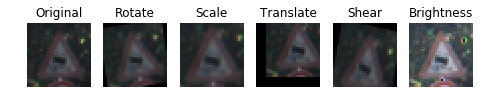

In [6]:
image = X_train[2000, :, :, :]

transform_exmp1 = [image,
                   image_rotate(image, 10),
                   image_scale(image, 1.2),
                   image_translate(image, 5, -5),
                   image_shear(image, 10),
                   image_brightness(image, 2)]

transform_title = ['Original', 'Rotate', 'Scale', 'Translate', 'Shear', 'Brightness']
print("")
print('Original and augmented ones\n');
fig, sign = plt.subplots(1, 6, figsize=(8,5))
for i in range(6):
    sign[i].imshow(transform_exmp1[i])
    sign[i].axis('off')
    sign[i].set_title(transform_title[i])

### Here I use these data augmentation techniques on train data:

1. random rotate:        -20 ~ +20 degree
2. random scale:         0.5 ~ 1.5 scale
3. random translate:     -2 ~ +2 pixel
4. random shear:         -10 ~ 10 degree
5. random brightness:    0.5 ~ 2.0 factor

In [7]:
#Transform image according to given parameters
def random_image_transform(image):
    
    randomAngle = random.uniform(-20, 20)
    output = image_rotate(image, randomAngle)
    
    randomScale = random.uniform(0.5, 1.5)
    output = image_scale(output, randomScale)
    
    randomFactor = random.uniform(0.5, 2.0)
    output = image_brightness(output, randomFactor)

    randomX = random.uniform(-2, 2)
    randomY = random.uniform(-2, 2)
    output = image_translate(output, randomX, randomY)
    
    randomShear = random.uniform(-10, 10)
    output = image_shear(output, randomShear)
    
    return output

### To keep the class balance, we generate the image in order to make equal image numbers of each class

In [8]:
#Generate the image in each class with the same number
max_images_per_class=np.max(y_train_dis)+1000

import numpy as np

new_train=[]
new_label=[]

while np.sum(y_train_dis) < n_classes * max_images_per_class:
    for index, image in enumerate(X_train):
        img_class = y_train[index]
        
        if y_train_dis[img_class] < max_images_per_class:
            
            new_train.append(random_image_transform(image))
            new_label.append(img_class)
            y_train_dis[img_class] += 1

X_train_n = np.append(X_train, new_train, axis=0)
y_train_n = np.append(y_train, new_label, axis=0)

X_train = X_train_n
y_train = y_train_n

### Apply Center normalizing and converting to grayscale on new trained data
1. Center Normalize: In order to decrease the influence of the big pixel values from images, make the network parameters updating more fast, center normalize image data into [ -1 , 1].
2. Grayscale: in order to reduce input data volume and training time, also because the color makes almost no contribution in classification.
3. Equal histogram: in order to normalize image brightness and make contrast enhancement.

In [9]:
#Center normalize
def center_normalize(img):
    
    img = img.astype('float32')
    img = (img - 128)/128
    return img

#Grayscale
def grayscale(image):
    
    imgs = np.ndarray((image.shape[0], 32, 32, 1), dtype=np.uint8)
    for i, img in enumerate(image):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = np.expand_dims(img, axis=2)
        imgs[i] = img
    
    return imgs

def preprocess(img):
    
    img = grayscale(img)
    img = center_normalize(img)
    return img

In [10]:
# Preprocess the data
X_train_preprocess = preprocess(X_train)
X_valid_preprocess = preprocess(X_valid)
X_test_preprocess = preprocess(X_test)

print("Number of preprocessed training data =", X_train_preprocess.shape[0])
print("Number of preprocessed validation data =", X_valid_preprocess.shape[0])
print("Number of testing data =", X_test_preprocess.shape[0])
print("Train data shape =", X_train_preprocess.shape[1:4])


X_train = X_train_preprocess
X_valid = X_valid_preprocess
X_test = X_test_preprocess

Number of preprocessed training data = 129430
Number of preprocessed validation data = 4410
Number of testing data = 12630
Train data shape = (32, 32, 1)


### Show some traffic sign ones after data augmentation and preprocess

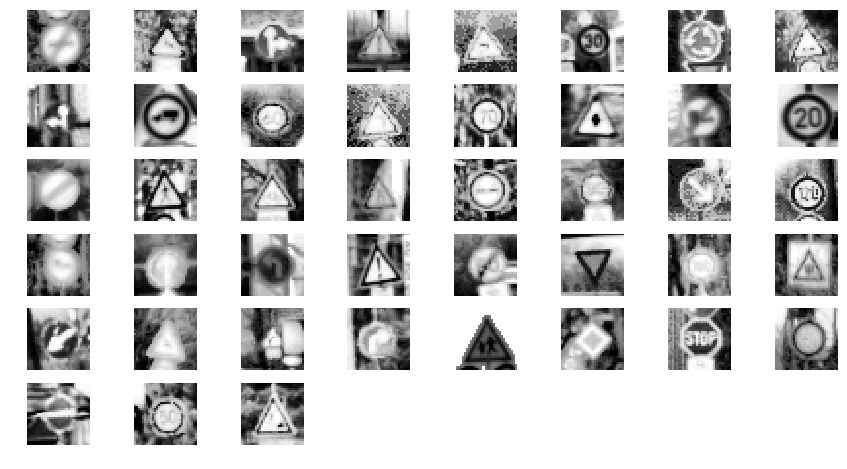

In [11]:
signs = []
caches = []
for index, label in enumerate(y_train):
    if label not in caches:
        caches.append(label)
        signs.append((label, index))

# Show a random collection of the preprocessed images
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(8)

for index, sign in enumerate(signs):
    ax = fig.add_subplot(6, 8, index + 1)
    ax.axis('off')
    image = X_train[sign[1]].squeeze()
    ax.imshow(image, cmap='gray')

----

## Step 2: Design and Test a Model Architecture

### Setup TensorFlow

In [12]:
import tensorflow as tf

EPOCHS = 500
BATCH_SIZE = 256
KEEP_PROB= 0.5

### Model Architecture
1. I choose the modified LeNet network because LeNet network has very good performance in handwriting recognition, so I want to try it in traffic sign classification
2. But the initial LeNet architecture may probably have overfitting problem
3. So I use dropout function on FC2 layer and L2 regularization to avoid the overfitting problem

In [24]:
from tensorflow.contrib.layers import flatten

def LeNetEx(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation.
    conv2 = tf.nn.relu(conv2)
    
    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)
    
    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation.
    fc2    = tf.nn.relu(fc2)
    #dropout
    fc2    = tf.nn.dropout(fc2, keep_prob)
    
    #Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    l2_loss = tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv1_b) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(conv2_b)+tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc1_b)+tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc2_b)+tf.nn.l2_loss(fc3_W) + tf.nn.l2_loss(fc3_b)
    return logits,l2_loss

### Design new model
Found in model training step, train loss no longer decline at around 0.7, according to the experience that the complexity of the network is not enough, so enhance the complexity of the network and use batch_normalization to avoid data distribution changing after each weight update step. 

### Train, Validate and Test the Model

In [13]:
#Placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

### Train Pipeline

In [26]:
rate = 0.005

logits,l2loss = LeNetEx(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

##L2 regularization preventing overfitting 
num_examples = len(X_train)
beta = 0.002
loss_operation = tf.reduce_mean(cross_entropy)+beta*l2loss
global_step = tf.Variable(0)
#learning rate set as exponential_decay 
learning_rate = tf.train.exponential_decay(rate,global_step,decay_steps=num_examples/BATCH_SIZE,decay_rate=0.98,staircase=True) 
training_operation = tf.train.AdamOptimizer(learning_rate).minimize(loss_operation,global_step=global_step)

### Model Evaluation

In [27]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        #loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y})
        #print("Evaluate Loss = {:.3f}".format(loss))
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
#Refer to https://github.com/martin-gorner/tensorflow-mnist-tutorial/blob/master/mnist_4.1_batchnorm_five_layers_relu.py
from sklearn.utils import shuffle

# input X: 32x32 grayscale images, the first dimension (None) will index the images in the mini-batch
x = tf.placeholder(tf.float32, [None, 32, 32, 1])
# correct answers will go here
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# variable learning rate
lr = tf.placeholder(tf.float32)

tst = tf.placeholder(tf.bool)
# training iteration
iter = tf.placeholder(tf.int32)


# five layers and their number of neurons (tha last layer has 10 softmax neurons)
L = 500
M = 300
N = 200
P = 100
Q = n_classes

W1 = tf.Variable(tf.truncated_normal([1024, L], stddev=0.1))  # 1024 = 32 * 32
B1 = tf.Variable(tf.zeros(L))
W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
B2 = tf.Variable(tf.zeros(M))
W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
B3 = tf.Variable(tf.zeros(N))
W4 = tf.Variable(tf.truncated_normal([N, P], stddev=0.1))
B4 = tf.Variable(tf.zeros(P))
W5 = tf.Variable(tf.truncated_normal([P, Q], stddev=0.1))
B5 = tf.Variable(tf.zeros(Q))


def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_averages

def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    return Ylogits, tf.no_op()


#New model
XX = tf.reshape(x, [-1, 1024])

# batch norm scaling is not useful with relus
# batch norm offsets are used instead of biases

Y1l = tf.matmul(XX, W1)
Y1bn, update_ema1 = batchnorm(Y1l, tst, iter, B1)
Y1 = tf.nn.relu(Y1bn)

Y2l = tf.matmul(Y1, W2)
Y2bn, update_ema2 = batchnorm(Y2l, tst, iter, B2)
Y2 = tf.nn.relu(Y2bn)

Y3l = tf.matmul(Y2, W3)
Y3bn, update_ema3 = batchnorm(Y3l, tst, iter, B3)
Y3 = tf.nn.relu(Y3bn)

Y4l = tf.matmul(Y3, W4)
Y4bn, update_ema4 = batchnorm(Y4l, tst, iter, B4)
Y4 = tf.nn.relu(Y4bn)

Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

l2_loss = tf.nn.l2_loss(W1) + tf.nn.l2_loss(B1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(B2)+tf.nn.l2_loss(W3) + tf.nn.l2_loss(B3)+tf.nn.l2_loss(W4) + tf.nn.l2_loss(B4)+tf.nn.l2_loss(W5) + tf.nn.l2_loss(B5)

update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=Ylogits)

cross_entropy = tf.reduce_mean(cross_entropy)*BATCH_SIZE

correct_prediction = tf.equal(tf.argmax(Ylogits, 1), tf.argmax(one_hot_y, 1))

accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

rate=0.004
##L2 regularization preventing overfitting 
num_examples = len(X_train)
beta = 0.002
loss_operation = tf.reduce_mean(cross_entropy)+beta*l2_loss
global_step = tf.Variable(0)
#learning rate set as exponential_decay 
learning_rate = tf.train.exponential_decay(rate,global_step,decay_steps=num_examples/BATCH_SIZE,decay_rate=0.98,staircase=True) 
training_operation = tf.train.AdamOptimizer(learning_rate).minimize(loss_operation,global_step=global_step)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, tst: False})
        #loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y})
        #print("Evaluate Loss = {:.3f}".format(loss))
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



num_examples = len(X_train)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())


    #learning rate decay (without batch norm)
    #max_learning_rate = 0.003
    #min_learning_rate = 0.0001
    #decay_speed = 2000
    # learning rate decay (with batch norm)
    #max_learning_rate = 0.03
    #min_learning_rate = 0.0001
    #decay_speed = 1000.0
    #learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)

    print("Training...")
    print()
    i=0
    for ii in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            #train step
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, tst: False})
            sess.run(update_ema, feed_dict={x: batch_x, y: batch_y, tst: False, iter: i})
            
        # valid set accurcy
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(ii+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        i=i+1


Training...

EPOCH 1 ...
Validation Accuracy = 0.239



### Train the Model

In [ ]:
from sklearn.utils import shuffle
num_examples = len(X_train)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:KEEP_PROB})
            #loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.0})
            #lr = sess.run(learning_rate)
            #print("Train Loss = {:.3f}".format(loss))
            #print("Learning Rate = {:.3f}".format(lr))
            
            if not i%10:  
                H = sess.run(loss_operation,feed_dict={x: batch_x, y: batch_y,keep_prob:1.0})  
                lr = sess.run(learning_rate)  
                print ("loss_operation: ",H,"\t","learning_rate: ",lr)  
                if H<1e-1:  #采用stop early 的方法防止过拟合，节省训练时间。  
                    break 
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

loss_operation:  4.22122 	 learning_rate:  0.005
loss_operation:  4.22324 	 learning_rate:  0.005
loss_operation:  4.20478 	 learning_rate:  0.005
loss_operation:  4.18805 	 learning_rate:  0.005
loss_operation:  4.17394 	 learning_rate:  0.005
loss_operation:  4.1597 	 learning_rate:  0.005
loss_operation:  4.14726 	 learning_rate:  0.005
loss_operation:  4.13213 	 learning_rate:  0.005
loss_operation:  4.11696 	 learning_rate:  0.005
loss_operation:  4.09899 	 learning_rate:  0.005
loss_operation:  4.08638 	 learning_rate:  0.005
loss_operation:  4.07089 	 learning_rate:  0.005
loss_operation:  4.05704 	 learning_rate:  0.005
loss_operation:  4.04445 	 learning_rate:  0.005
loss_operation:  4.03172 	 learning_rate:  0.005
loss_operation:  4.01916 	 learning_rate:  0.005
loss_operation:  4.00347 	 learning_rate:  0.005
loss_operation:  3.99392 	 learning_rate:  0.005
loss_operation:  3.98403 	 learning_rate:  0.005
loss_operation:  3.96204 	 learning_rate:  0.005
loss_ope

loss_operation:  2.05455 	 learning_rate:  0.005
loss_operation:  2.2074 	 learning_rate:  0.005
loss_operation:  2.05607 	 learning_rate:  0.005
loss_operation:  2.13454 	 learning_rate:  0.005
loss_operation:  2.02603 	 learning_rate:  0.005
loss_operation:  2.00954 	 learning_rate:  0.005
loss_operation:  1.98025 	 learning_rate:  0.005
loss_operation:  2.04998 	 learning_rate:  0.005
loss_operation:  2.06409 	 learning_rate:  0.005
loss_operation:  2.02186 	 learning_rate:  0.005
loss_operation:  2.11445 	 learning_rate:  0.005
loss_operation:  1.98982 	 learning_rate:  0.005
loss_operation:  2.15956 	 learning_rate:  0.005
loss_operation:  2.03422 	 learning_rate:  0.005
loss_operation:  1.96045 	 learning_rate:  0.005
loss_operation:  2.07812 	 learning_rate:  0.005
loss_operation:  2.0344 	 learning_rate:  0.005
loss_operation:  2.00951 	 learning_rate:  0.005
loss_operation:  2.07559 	 learning_rate:  0.005
loss_operation:  2.08339 	 learning_rate:  0.005
loss_operation:  2.010

loss_operation:  1.76973 	 learning_rate:  0.005
loss_operation:  1.7653 	 learning_rate:  0.005
loss_operation:  1.80787 	 learning_rate:  0.005
loss_operation:  1.84357 	 learning_rate:  0.005
loss_operation:  1.79128 	 learning_rate:  0.005
loss_operation:  1.74213 	 learning_rate:  0.005
loss_operation:  1.74445 	 learning_rate:  0.005
loss_operation:  1.92582 	 learning_rate:  0.005
loss_operation:  1.68766 	 learning_rate:  0.005
loss_operation:  1.63166 	 learning_rate:  0.005
loss_operation:  1.73868 	 learning_rate:  0.005
loss_operation:  1.73482 	 learning_rate:  0.005
loss_operation:  1.57174 	 learning_rate:  0.005
loss_operation:  1.70074 	 learning_rate:  0.005
loss_operation:  1.66984 	 learning_rate:  0.005
loss_operation:  1.71546 	 learning_rate:  0.005
loss_operation:  1.61193 	 learning_rate:  0.005
loss_operation:  1.5425 	 learning_rate:  0.005
loss_operation:  1.7647 	 learning_rate:  0.005
loss_operation:  1.69775 	 learning_rate:  0.005
loss_operation:  1.7452

loss_operation:  1.16401 	 learning_rate:  0.00408536
loss_operation:  1.11669 	 learning_rate:  0.00408536
loss_operation:  1.13022 	 learning_rate:  0.00408536
loss_operation:  1.05037 	 learning_rate:  0.00408536
loss_operation:  1.11992 	 learning_rate:  0.00408536
loss_operation:  1.2382 	 learning_rate:  0.00408536
loss_operation:  1.10847 	 learning_rate:  0.00408536
loss_operation:  1.15276 	 learning_rate:  0.00408536
loss_operation:  1.13865 	 learning_rate:  0.00408536
loss_operation:  1.16041 	 learning_rate:  0.00408536
loss_operation:  1.2399 	 learning_rate:  0.00408536
loss_operation:  1.25061 	 learning_rate:  0.00408536
loss_operation:  1.15047 	 learning_rate:  0.00408536
loss_operation:  1.01822 	 learning_rate:  0.00408536
loss_operation:  1.06988 	 learning_rate:  0.00408536
loss_operation:  1.17769 	 learning_rate:  0.00408536
loss_operation:  1.18564 	 learning_rate:  0.00408536
loss_operation:  1.17264 	 learning_rate:  0.00408536
loss_operation:  1.11932 	 lea

loss_operation:  1.17167 	 learning_rate:  0.00408536
loss_operation:  1.07858 	 learning_rate:  0.00408536
loss_operation:  1.22341 	 learning_rate:  0.00408536
loss_operation:  1.1829 	 learning_rate:  0.00408536
loss_operation:  1.12253 	 learning_rate:  0.00408536
loss_operation:  1.12999 	 learning_rate:  0.00408536
loss_operation:  1.10995 	 learning_rate:  0.00408536
loss_operation:  1.13748 	 learning_rate:  0.00408536
loss_operation:  1.20993 	 learning_rate:  0.00408536
loss_operation:  1.1428 	 learning_rate:  0.00408536
loss_operation:  1.1544 	 learning_rate:  0.00408536
loss_operation:  1.19336 	 learning_rate:  0.00408536
loss_operation:  1.18476 	 learning_rate:  0.00408536
loss_operation:  1.17307 	 learning_rate:  0.00408536
loss_operation:  1.18079 	 learning_rate:  0.00408536
loss_operation:  1.05596 	 learning_rate:  0.00408536
loss_operation:  1.0962 	 learning_rate:  0.00408536
loss_operation:  1.10337 	 learning_rate:  0.00408536
loss_operation:  1.12422 	 learn

loss_operation:  1.14517 	 learning_rate:  0.00408536
loss_operation:  1.05856 	 learning_rate:  0.00408536
loss_operation:  1.1573 	 learning_rate:  0.00408536
loss_operation:  0.997411 	 learning_rate:  0.00408536
loss_operation:  1.16293 	 learning_rate:  0.00408536
loss_operation:  1.19471 	 learning_rate:  0.00408536
loss_operation:  1.10539 	 learning_rate:  0.00408536
loss_operation:  1.20255 	 learning_rate:  0.00408536
loss_operation:  1.26206 	 learning_rate:  0.00408536
loss_operation:  1.25281 	 learning_rate:  0.00408536
loss_operation:  1.04977 	 learning_rate:  0.00408536
loss_operation:  1.2361 	 learning_rate:  0.00400366
loss_operation:  1.28366 	 learning_rate:  0.00400366
loss_operation:  1.18903 	 learning_rate:  0.00400366
loss_operation:  1.15419 	 learning_rate:  0.00400366
loss_operation:  1.1343 	 learning_rate:  0.00400366
loss_operation:  1.25677 	 learning_rate:  0.00400366
loss_operation:  1.14818 	 learning_rate:  0.00400366
EPOCH 11 ...
Validation Accura

loss_operation:  1.11805 	 learning_rate:  0.00333804
loss_operation:  0.988766 	 learning_rate:  0.00333804
loss_operation:  1.09378 	 learning_rate:  0.00333804
loss_operation:  1.22219 	 learning_rate:  0.00333804
loss_operation:  1.11042 	 learning_rate:  0.00333804
loss_operation:  1.04257 	 learning_rate:  0.00333804
loss_operation:  1.09591 	 learning_rate:  0.00333804
loss_operation:  1.05983 	 learning_rate:  0.00333804
loss_operation:  0.944152 	 learning_rate:  0.00333804
loss_operation:  1.16804 	 learning_rate:  0.00333804
loss_operation:  1.08155 	 learning_rate:  0.00333804
loss_operation:  1.14968 	 learning_rate:  0.00333804
loss_operation:  1.19077 	 learning_rate:  0.00333804
loss_operation:  1.13395 	 learning_rate:  0.00333804
loss_operation:  1.12949 	 learning_rate:  0.00333804
loss_operation:  1.05894 	 learning_rate:  0.00333804
loss_operation:  1.15484 	 learning_rate:  0.00333804
loss_operation:  1.00259 	 learning_rate:  0.00333804
loss_operation:  1.07145 	

loss_operation:  1.02596 	 learning_rate:  0.00333804
loss_operation:  1.17009 	 learning_rate:  0.00333804
loss_operation:  1.11271 	 learning_rate:  0.00333804
loss_operation:  1.14421 	 learning_rate:  0.00333804
loss_operation:  1.08532 	 learning_rate:  0.00333804
loss_operation:  1.10925 	 learning_rate:  0.00333804
loss_operation:  1.05954 	 learning_rate:  0.00333804
loss_operation:  1.1491 	 learning_rate:  0.00333804
loss_operation:  1.1436 	 learning_rate:  0.00333804
loss_operation:  0.987483 	 learning_rate:  0.00333804
loss_operation:  1.15583 	 learning_rate:  0.00333804
loss_operation:  1.08125 	 learning_rate:  0.00333804
loss_operation:  1.13942 	 learning_rate:  0.00333804
loss_operation:  1.14647 	 learning_rate:  0.00333804
loss_operation:  1.11426 	 learning_rate:  0.00333804
loss_operation:  1.03703 	 learning_rate:  0.00333804
loss_operation:  1.16952 	 learning_rate:  0.00333804
loss_operation:  1.13325 	 learning_rate:  0.00333804
loss_operation:  1.07164 	 le

loss_operation:  1.0545 	 learning_rate:  0.00272742
loss_operation:  1.07571 	 learning_rate:  0.00272742
loss_operation:  1.00726 	 learning_rate:  0.00272742
loss_operation:  1.06821 	 learning_rate:  0.00272742
loss_operation:  1.0725 	 learning_rate:  0.00272742
loss_operation:  1.07584 	 learning_rate:  0.00272742
loss_operation:  1.05724 	 learning_rate:  0.00272742
loss_operation:  1.05113 	 learning_rate:  0.00272742
loss_operation:  1.0659 	 learning_rate:  0.00272742
loss_operation:  1.06357 	 learning_rate:  0.00272742
loss_operation:  1.13327 	 learning_rate:  0.00272742
loss_operation:  1.13275 	 learning_rate:  0.00272742
loss_operation:  1.11508 	 learning_rate:  0.00272742
loss_operation:  1.05195 	 learning_rate:  0.00272742
loss_operation:  0.930712 	 learning_rate:  0.00272742
loss_operation:  1.0719 	 learning_rate:  0.00272742
loss_operation:  1.01707 	 learning_rate:  0.00272742
loss_operation:  0.912243 	 learning_rate:  0.00272742
loss_operation:  1.04878 	 lea

loss_operation:  1.06627 	 learning_rate:  0.00272742
loss_operation:  1.19152 	 learning_rate:  0.00272742
loss_operation:  1.04085 	 learning_rate:  0.00272742
loss_operation:  1.02776 	 learning_rate:  0.00272742
loss_operation:  0.98104 	 learning_rate:  0.00272742
loss_operation:  1.11904 	 learning_rate:  0.00272742
loss_operation:  1.12793 	 learning_rate:  0.00272742
loss_operation:  1.07854 	 learning_rate:  0.00272742
loss_operation:  1.01364 	 learning_rate:  0.00272742
loss_operation:  1.20616 	 learning_rate:  0.00272742
loss_operation:  1.14358 	 learning_rate:  0.00272742
loss_operation:  1.10651 	 learning_rate:  0.00272742
loss_operation:  1.01897 	 learning_rate:  0.00272742
loss_operation:  1.09006 	 learning_rate:  0.00272742
loss_operation:  1.10825 	 learning_rate:  0.00272742
loss_operation:  1.07607 	 learning_rate:  0.00272742
loss_operation:  1.15892 	 learning_rate:  0.00272742
loss_operation:  1.01455 	 learning_rate:  0.00272742
loss_operation:  1.09586 	 l

loss_operation:  0.989349 	 learning_rate:  0.00272742
loss_operation:  1.11122 	 learning_rate:  0.00272742
loss_operation:  1.07947 	 learning_rate:  0.00272742
loss_operation:  1.06833 	 learning_rate:  0.00272742
loss_operation:  0.990142 	 learning_rate:  0.00272742
loss_operation:  1.1186 	 learning_rate:  0.00272742
loss_operation:  0.97005 	 learning_rate:  0.00272742
loss_operation:  1.06468 	 learning_rate:  0.00272742
loss_operation:  1.01447 	 learning_rate:  0.00272742
loss_operation:  1.02776 	 learning_rate:  0.00272742
loss_operation:  0.939374 	 learning_rate:  0.00272742
loss_operation:  1.00438 	 learning_rate:  0.00272742
loss_operation:  0.996315 	 learning_rate:  0.00272742
loss_operation:  1.07191 	 learning_rate:  0.00272742
loss_operation:  1.19689 	 learning_rate:  0.00272742
loss_operation:  1.09942 	 learning_rate:  0.00272742
loss_operation:  1.16984 	 learning_rate:  0.00272742
loss_operation:  1.01266 	 learning_rate:  0.00272742
loss_operation:  1.05785 

loss_operation:  1.06588 	 learning_rate:  0.0022285
loss_operation:  1.01967 	 learning_rate:  0.0022285
loss_operation:  1.0298 	 learning_rate:  0.0022285
loss_operation:  0.989006 	 learning_rate:  0.0022285
loss_operation:  0.999924 	 learning_rate:  0.0022285
loss_operation:  1.11536 	 learning_rate:  0.0022285
loss_operation:  0.902927 	 learning_rate:  0.0022285
loss_operation:  1.02075 	 learning_rate:  0.0022285
loss_operation:  1.0095 	 learning_rate:  0.0022285
loss_operation:  0.915222 	 learning_rate:  0.0022285
loss_operation:  0.89963 	 learning_rate:  0.0022285
loss_operation:  1.10155 	 learning_rate:  0.0022285
loss_operation:  1.01373 	 learning_rate:  0.0022285
loss_operation:  1.03283 	 learning_rate:  0.0022285
loss_operation:  1.09923 	 learning_rate:  0.0022285
loss_operation:  0.986529 	 learning_rate:  0.0022285
loss_operation:  0.95426 	 learning_rate:  0.0022285
loss_operation:  1.01688 	 learning_rate:  0.0022285
loss_operation:  1.01662 	 learning_rate:  

loss_operation:  1.03562 	 learning_rate:  0.0022285
loss_operation:  1.01751 	 learning_rate:  0.0022285
loss_operation:  1.11163 	 learning_rate:  0.0022285
loss_operation:  0.928339 	 learning_rate:  0.0022285
loss_operation:  1.00274 	 learning_rate:  0.0022285
loss_operation:  1.04512 	 learning_rate:  0.0022285
loss_operation:  0.989316 	 learning_rate:  0.0022285
loss_operation:  0.983798 	 learning_rate:  0.0022285
loss_operation:  1.05207 	 learning_rate:  0.0022285
loss_operation:  0.994272 	 learning_rate:  0.0022285
loss_operation:  1.11102 	 learning_rate:  0.0022285
loss_operation:  0.957965 	 learning_rate:  0.0022285
loss_operation:  1.02972 	 learning_rate:  0.0022285
loss_operation:  1.09641 	 learning_rate:  0.0022285
loss_operation:  1.08287 	 learning_rate:  0.0022285
loss_operation:  1.03601 	 learning_rate:  0.0022285
loss_operation:  0.972962 	 learning_rate:  0.0022285
loss_operation:  1.00235 	 learning_rate:  0.0022285
loss_operation:  0.929085 	 learning_rat

loss_operation:  0.983845 	 learning_rate:  0.0022285
loss_operation:  1.06676 	 learning_rate:  0.0022285
loss_operation:  0.959572 	 learning_rate:  0.0022285
loss_operation:  1.01923 	 learning_rate:  0.0022285
loss_operation:  1.04906 	 learning_rate:  0.0022285
loss_operation:  1.02215 	 learning_rate:  0.0022285
loss_operation:  1.02824 	 learning_rate:  0.0022285
loss_operation:  1.05862 	 learning_rate:  0.0022285
loss_operation:  0.999564 	 learning_rate:  0.0022285
loss_operation:  1.0558 	 learning_rate:  0.0022285
loss_operation:  1.0079 	 learning_rate:  0.0022285
loss_operation:  0.948814 	 learning_rate:  0.0022285
loss_operation:  0.987416 	 learning_rate:  0.0022285
loss_operation:  1.0203 	 learning_rate:  0.0022285
loss_operation:  1.05673 	 learning_rate:  0.0022285
loss_operation:  0.959006 	 learning_rate:  0.00218393
loss_operation:  0.991055 	 learning_rate:  0.00218393
loss_operation:  1.01724 	 learning_rate:  0.00218393
loss_operation:  1.02981 	 learning_rat

loss_operation:  0.982774 	 learning_rate:  0.00182085
loss_operation:  0.898433 	 learning_rate:  0.00182085
loss_operation:  0.877265 	 learning_rate:  0.00182085
loss_operation:  1.06314 	 learning_rate:  0.00182085
loss_operation:  0.884611 	 learning_rate:  0.00182085
loss_operation:  0.978821 	 learning_rate:  0.00182085
loss_operation:  1.04537 	 learning_rate:  0.00182085
loss_operation:  0.949914 	 learning_rate:  0.00182085
loss_operation:  1.026 	 learning_rate:  0.00182085
loss_operation:  0.96993 	 learning_rate:  0.00182085
loss_operation:  0.993353 	 learning_rate:  0.00182085
loss_operation:  0.979315 	 learning_rate:  0.00182085
loss_operation:  1.04646 	 learning_rate:  0.00182085
loss_operation:  1.17922 	 learning_rate:  0.00182085
loss_operation:  1.11215 	 learning_rate:  0.00182085
loss_operation:  1.03897 	 learning_rate:  0.00182085
loss_operation:  1.02356 	 learning_rate:  0.00182085
loss_operation:  1.17453 	 learning_rate:  0.00182085
loss_operation:  1.098

loss_operation:  1.03578 	 learning_rate:  0.00182085
loss_operation:  0.869335 	 learning_rate:  0.00182085
loss_operation:  0.972767 	 learning_rate:  0.00182085
loss_operation:  1.04241 	 learning_rate:  0.00182085
loss_operation:  0.916592 	 learning_rate:  0.00182085
loss_operation:  1.05391 	 learning_rate:  0.00182085
loss_operation:  0.938002 	 learning_rate:  0.00182085
loss_operation:  0.99972 	 learning_rate:  0.00182085
loss_operation:  0.997393 	 learning_rate:  0.00182085
loss_operation:  1.03724 	 learning_rate:  0.00182085
loss_operation:  0.975201 	 learning_rate:  0.00182085
loss_operation:  1.00805 	 learning_rate:  0.00182085
loss_operation:  1.01158 	 learning_rate:  0.00182085
loss_operation:  0.95467 	 learning_rate:  0.00182085
loss_operation:  0.870474 	 learning_rate:  0.00182085
loss_operation:  1.09015 	 learning_rate:  0.00182085
loss_operation:  0.935815 	 learning_rate:  0.00182085
loss_operation:  0.888972 	 learning_rate:  0.00182085
loss_operation:  1.

loss_operation:  0.926577 	 learning_rate:  0.00178443
loss_operation:  0.924849 	 learning_rate:  0.00178443
loss_operation:  1.05464 	 learning_rate:  0.00178443
loss_operation:  1.0258 	 learning_rate:  0.00178443
loss_operation:  1.052 	 learning_rate:  0.00178443
loss_operation:  0.880305 	 learning_rate:  0.00178443
loss_operation:  0.959002 	 learning_rate:  0.00178443
loss_operation:  0.999154 	 learning_rate:  0.00178443
loss_operation:  1.06362 	 learning_rate:  0.00178443
loss_operation:  0.900468 	 learning_rate:  0.00178443
loss_operation:  1.01923 	 learning_rate:  0.00178443
EPOCH 51 ...
Validation Accuracy = 0.956

EPOCH 52 ...
Validation Accuracy = 0.949

EPOCH 53 ...
Validation Accuracy = 0.954

EPOCH 54 ...
Validation Accuracy = 0.950

EPOCH 55 ...
Validation Accuracy = 0.956

EPOCH 56 ...
Validation Accuracy = 0.949

EPOCH 57 ...
Validation Accuracy = 0.952

EPOCH 58 ...
Validation Accuracy = 0.952

EPOCH 59 ...
Validation Accuracy = 0.954

EPOCH 60 ...
Validation A

loss_operation:  0.954925 	 learning_rate:  0.00148777
loss_operation:  1.05232 	 learning_rate:  0.00148777
loss_operation:  1.03142 	 learning_rate:  0.00148777
loss_operation:  1.00618 	 learning_rate:  0.00148777
loss_operation:  0.900486 	 learning_rate:  0.00148777
loss_operation:  0.974273 	 learning_rate:  0.00148777
loss_operation:  0.954829 	 learning_rate:  0.00148777
loss_operation:  1.00632 	 learning_rate:  0.00148777
loss_operation:  0.909544 	 learning_rate:  0.00148777
loss_operation:  0.936445 	 learning_rate:  0.00148777
loss_operation:  1.00772 	 learning_rate:  0.00148777
loss_operation:  0.869177 	 learning_rate:  0.00148777
loss_operation:  0.91049 	 learning_rate:  0.00148777
loss_operation:  0.999547 	 learning_rate:  0.00148777
loss_operation:  0.965416 	 learning_rate:  0.00148777
loss_operation:  0.950264 	 learning_rate:  0.00148777
loss_operation:  0.948906 	 learning_rate:  0.00148777
loss_operation:  0.979615 	 learning_rate:  0.00148777
loss_operation: 

loss_operation:  0.865183 	 learning_rate:  0.00148777
loss_operation:  1.01942 	 learning_rate:  0.00148777
loss_operation:  0.980118 	 learning_rate:  0.00148777
loss_operation:  0.925882 	 learning_rate:  0.00148777
loss_operation:  0.948849 	 learning_rate:  0.00148777
loss_operation:  0.955681 	 learning_rate:  0.00148777
loss_operation:  1.09767 	 learning_rate:  0.00148777
loss_operation:  1.04808 	 learning_rate:  0.00148777
loss_operation:  1.02503 	 learning_rate:  0.00148777
loss_operation:  1.12324 	 learning_rate:  0.00148777
loss_operation:  0.948126 	 learning_rate:  0.00148777
loss_operation:  0.973777 	 learning_rate:  0.00148777
loss_operation:  0.973621 	 learning_rate:  0.00148777
loss_operation:  0.958109 	 learning_rate:  0.00148777
loss_operation:  0.978648 	 learning_rate:  0.00148777
loss_operation:  0.945335 	 learning_rate:  0.00148777
loss_operation:  1.00758 	 learning_rate:  0.00148777
loss_operation:  0.970052 	 learning_rate:  0.00148777
loss_operation: 

EPOCH 65 ...
Validation Accuracy = 0.957

EPOCH 66 ...
Validation Accuracy = 0.955

EPOCH 67 ...
Validation Accuracy = 0.957

EPOCH 68 ...
Validation Accuracy = 0.958

EPOCH 69 ...
Validation Accuracy = 0.957

EPOCH 70 ...
Validation Accuracy = 0.960

loss_operation:  0.990379 	 learning_rate:  0.00121561
loss_operation:  1.02048 	 learning_rate:  0.00121561
loss_operation:  1.00561 	 learning_rate:  0.00121561
loss_operation:  0.977466 	 learning_rate:  0.00121561
loss_operation:  0.865636 	 learning_rate:  0.00121561
loss_operation:  0.945016 	 learning_rate:  0.00121561
loss_operation:  0.951361 	 learning_rate:  0.00121561
loss_operation:  0.939158 	 learning_rate:  0.00121561
loss_operation:  0.923508 	 learning_rate:  0.00121561
loss_operation:  1.01655 	 learning_rate:  0.00121561
loss_operation:  0.906294 	 learning_rate:  0.00121561
loss_operation:  0.878315 	 learning_rate:  0.00121561
loss_operation:  0.931136 	 learning_rate:  0.00121561
loss_operation:  1.05111 	 learning_

loss_operation:  0.916055 	 learning_rate:  0.00121561
loss_operation:  1.05129 	 learning_rate:  0.00121561
loss_operation:  0.886972 	 learning_rate:  0.00121561
loss_operation:  0.952366 	 learning_rate:  0.00121561
loss_operation:  0.892266 	 learning_rate:  0.00121561
loss_operation:  0.888637 	 learning_rate:  0.00121561
loss_operation:  0.93556 	 learning_rate:  0.00121561
loss_operation:  1.02231 	 learning_rate:  0.00121561
loss_operation:  0.959124 	 learning_rate:  0.00121561
loss_operation:  1.03594 	 learning_rate:  0.00121561
loss_operation:  0.896691 	 learning_rate:  0.00121561
loss_operation:  0.919308 	 learning_rate:  0.00121561
loss_operation:  0.959656 	 learning_rate:  0.00121561
loss_operation:  1.03572 	 learning_rate:  0.00121561
loss_operation:  0.846429 	 learning_rate:  0.00121561
loss_operation:  0.995677 	 learning_rate:  0.00121561
loss_operation:  0.939338 	 learning_rate:  0.00121561
loss_operation:  0.95266 	 learning_rate:  0.00121561
loss_operation: 

loss_operation:  1.04291 	 learning_rate:  0.00121561
loss_operation:  0.981582 	 learning_rate:  0.00121561
loss_operation:  0.945875 	 learning_rate:  0.00121561
loss_operation:  0.957022 	 learning_rate:  0.00121561
loss_operation:  0.895234 	 learning_rate:  0.00121561
loss_operation:  0.948989 	 learning_rate:  0.00121561
loss_operation:  0.918316 	 learning_rate:  0.00121561
loss_operation:  1.03849 	 learning_rate:  0.00121561
loss_operation:  0.947254 	 learning_rate:  0.00121561
loss_operation:  1.04964 	 learning_rate:  0.00121561
loss_operation:  1.07229 	 learning_rate:  0.00121561
loss_operation:  0.934716 	 learning_rate:  0.00121561
loss_operation:  0.973664 	 learning_rate:  0.00121561
loss_operation:  0.953584 	 learning_rate:  0.00121561
loss_operation:  0.880998 	 learning_rate:  0.00121561
loss_operation:  0.91601 	 learning_rate:  0.00121561
loss_operation:  0.938014 	 learning_rate:  0.00121561
loss_operation:  0.918852 	 learning_rate:  0.00121561
loss_operation:

loss_operation:  0.974208 	 learning_rate:  0.000993246
loss_operation:  0.921855 	 learning_rate:  0.000993246
loss_operation:  0.904414 	 learning_rate:  0.000993246
loss_operation:  0.897731 	 learning_rate:  0.000993246
loss_operation:  0.942491 	 learning_rate:  0.000993246
loss_operation:  0.886501 	 learning_rate:  0.000993246
loss_operation:  0.912514 	 learning_rate:  0.000993246
loss_operation:  0.806655 	 learning_rate:  0.000993246
loss_operation:  0.916207 	 learning_rate:  0.000993246
loss_operation:  1.04281 	 learning_rate:  0.000993246
loss_operation:  0.904117 	 learning_rate:  0.000993246
loss_operation:  0.854275 	 learning_rate:  0.000993246
loss_operation:  0.934968 	 learning_rate:  0.000993246
loss_operation:  0.958117 	 learning_rate:  0.000993246
loss_operation:  0.8483 	 learning_rate:  0.000993246
loss_operation:  0.949971 	 learning_rate:  0.000993246
loss_operation:  0.916058 	 learning_rate:  0.000993246
loss_operation:  0.908759 	 learning_rate:  0.00099

loss_operation:  0.983526 	 learning_rate:  0.000993246
loss_operation:  0.969956 	 learning_rate:  0.000993246
loss_operation:  0.936999 	 learning_rate:  0.000993246
loss_operation:  0.883523 	 learning_rate:  0.000993246
loss_operation:  0.931113 	 learning_rate:  0.000993246
loss_operation:  0.827216 	 learning_rate:  0.000993246
loss_operation:  0.916879 	 learning_rate:  0.000993246
loss_operation:  0.882317 	 learning_rate:  0.000993246
loss_operation:  0.912636 	 learning_rate:  0.000993246
loss_operation:  0.860854 	 learning_rate:  0.000993246
loss_operation:  0.966546 	 learning_rate:  0.000993246
loss_operation:  1.00769 	 learning_rate:  0.000993246
loss_operation:  0.967265 	 learning_rate:  0.000993246
loss_operation:  0.90094 	 learning_rate:  0.000993246
loss_operation:  0.963837 	 learning_rate:  0.000993246
loss_operation:  0.959848 	 learning_rate:  0.000993246
loss_operation:  0.927587 	 learning_rate:  0.000993246
loss_operation:  0.882591 	 learning_rate:  0.0009

loss_operation:  0.92457 	 learning_rate:  0.000993246
loss_operation:  0.884783 	 learning_rate:  0.000993246
loss_operation:  0.866037 	 learning_rate:  0.000993246
loss_operation:  0.94128 	 learning_rate:  0.000993246
loss_operation:  0.877935 	 learning_rate:  0.000993246
loss_operation:  0.941796 	 learning_rate:  0.000993246
loss_operation:  0.953973 	 learning_rate:  0.000993246
loss_operation:  1.03321 	 learning_rate:  0.000993246
loss_operation:  0.960452 	 learning_rate:  0.000993246
loss_operation:  0.897166 	 learning_rate:  0.000993246
loss_operation:  0.939856 	 learning_rate:  0.000993246
loss_operation:  0.898426 	 learning_rate:  0.000993246
loss_operation:  0.888863 	 learning_rate:  0.000993246
loss_operation:  0.83463 	 learning_rate:  0.000993246
loss_operation:  0.904909 	 learning_rate:  0.000993246
loss_operation:  0.971255 	 learning_rate:  0.000993246
loss_operation:  1.02465 	 learning_rate:  0.000993246
loss_operation:  0.971928 	 learning_rate:  0.0009932

loss_operation:  0.89614 	 learning_rate:  0.000811554
loss_operation:  0.932701 	 learning_rate:  0.000811554
loss_operation:  0.820855 	 learning_rate:  0.000811554
loss_operation:  0.904751 	 learning_rate:  0.000811554
loss_operation:  0.838155 	 learning_rate:  0.000811554
loss_operation:  0.945126 	 learning_rate:  0.000811554
loss_operation:  0.913975 	 learning_rate:  0.000811554
loss_operation:  1.0004 	 learning_rate:  0.000811554
loss_operation:  0.881914 	 learning_rate:  0.000811554
loss_operation:  0.886501 	 learning_rate:  0.000811554
loss_operation:  0.840215 	 learning_rate:  0.000811554
loss_operation:  0.967661 	 learning_rate:  0.000811554
loss_operation:  0.889218 	 learning_rate:  0.000811554
loss_operation:  0.90099 	 learning_rate:  0.000811554
loss_operation:  0.879378 	 learning_rate:  0.000811554
loss_operation:  0.88739 	 learning_rate:  0.000811554
loss_operation:  0.92058 	 learning_rate:  0.000811554
loss_operation:  0.887277 	 learning_rate:  0.00081155

loss_operation:  0.967134 	 learning_rate:  0.000811554
loss_operation:  0.956507 	 learning_rate:  0.000811554
loss_operation:  0.923747 	 learning_rate:  0.000811554
loss_operation:  0.875728 	 learning_rate:  0.000811554
loss_operation:  0.984464 	 learning_rate:  0.000811554
loss_operation:  0.854161 	 learning_rate:  0.000811554
loss_operation:  0.937392 	 learning_rate:  0.000811554
loss_operation:  0.936515 	 learning_rate:  0.000811554
loss_operation:  0.946544 	 learning_rate:  0.000811554
loss_operation:  1.06669 	 learning_rate:  0.000811554
loss_operation:  0.865988 	 learning_rate:  0.000811554
loss_operation:  0.848504 	 learning_rate:  0.000811554
loss_operation:  0.891756 	 learning_rate:  0.000811554
loss_operation:  0.913369 	 learning_rate:  0.000811554
loss_operation:  0.917968 	 learning_rate:  0.000811554
loss_operation:  0.885011 	 learning_rate:  0.000811554
loss_operation:  0.896264 	 learning_rate:  0.000811554
loss_operation:  0.838935 	 learning_rate:  0.000

loss_operation:  0.937271 	 learning_rate:  0.000811554
loss_operation:  0.901508 	 learning_rate:  0.000811554
loss_operation:  0.884318 	 learning_rate:  0.000811554
loss_operation:  0.877125 	 learning_rate:  0.000811554
loss_operation:  0.937882 	 learning_rate:  0.000811554
loss_operation:  1.02812 	 learning_rate:  0.000811554
loss_operation:  0.941136 	 learning_rate:  0.000811554
loss_operation:  0.964592 	 learning_rate:  0.000811554
loss_operation:  0.846199 	 learning_rate:  0.000811554
loss_operation:  0.987992 	 learning_rate:  0.000811554
loss_operation:  0.858426 	 learning_rate:  0.000811554
loss_operation:  0.962884 	 learning_rate:  0.000811554
loss_operation:  1.02078 	 learning_rate:  0.000811554
loss_operation:  0.964928 	 learning_rate:  0.000811554
loss_operation:  0.827509 	 learning_rate:  0.000811554
loss_operation:  1.01212 	 learning_rate:  0.000811554
loss_operation:  0.847642 	 learning_rate:  0.000811554
loss_operation:  0.954636 	 learning_rate:  0.00081

### Evaluate the Model

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

## Step 3: Test a Model on New Images


### Load and Output the Images

#### Here is five new German Traffic signs found on the web,and the images are visualized
The brightness and contrast of the five collected images are pretty good which may help the accuracy of prediction.

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from skimage import data, exposure, img_as_float
from PIL import ImageEnhance  

%matplotlib inline

import tensorflow as tf

from pandas.io.parsers import read_csv

ImagePath = './test/*.png'
test_images = []

for index, img in enumerate(glob.glob(ImagePath)):
    image = cv2.imread(img)
    image = cv2.resize(image, (32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image= exposure.adjust_gamma(image, 0.4) 
    image= exposure.adjust_log(image)
    test_images.append(image)

# Show original test images
figure = plt.figure()
figure.set_figwidth(12)
figure.set_figheight(6)

for index, image in enumerate(test_images):
    t = figure.add_subplot(1, 10, index + 1)
    t.axis('off')
    t.imshow(image)

#### Use previous pipeline to preprocess new test images

In [ ]:
X_test_new = np.array(test_images)
X_test_new = preprocess(X_test_new)

# Show preprocessed test images
figure = plt.figure()
figure.set_figwidth(12)
figure.set_figheight(6)

for index, image in enumerate(X_test_new):
    t = figure.add_subplot(1, 10, index + 1)
    t.axis('off')
    image = X_test_new[index].squeeze()
    t.imshow(image, cmap='gray')

### Predict the Sign Type for Each Image

#### Run the predictions here and use the model to output the prediction for each image.
#### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

In [ ]:
signnames = read_csv("signnames.csv").values[:, 1]
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, save_path='./lenet')
    
    # Calculate the top 5
    softmax_logits = tf.nn.softmax(logits)
    top_5 = tf.nn.top_k(softmax_logits, k=5)
    top_5_pred = sess.run(top_5, feed_dict={x: X_test_new, keep_prob: 1.0})
    
    predict_values = top_5_pred.values
    predict_indices = top_5_pred.indices
    
    for i, image in enumerate(X_test_new):
        predict = predict_values[i][0]
        signname = signnames[predict_indices[i][0].astype(int)]
        # print the sign name and its probability
        print('{} ({:.2f}%)'.format(signname, 100*predict))

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [ ]:
new_img_predict_accuracy = 4/10
print('Prediction accuracy on new images: ', new_img_predict_accuracy*100, '%')

#### compare the prediction accuracy of collected traffic signs from WEB and of the test dataset

In [ ]:
The accuracy on the captured images is X% while it was Y% on the testing set thus It seems the model is overfitting

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
# Top 5 softmax possibilities have been calculated above, now the output is visualized here. 
plt.figure(figsize=(16, 21))
for i in range(len(X_test_new)):
    plt.subplot(12, 2, 2*i+1)
    plt.imshow(test_images[i]) 
    plt.title(i)
    plt.axis('off')
    plt.subplot(12, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), predict_values[i, :])
    labs=[signnames[j] for j in predict_indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()